# Reinforcement Learning: Snake mit Q-Learning
Dieses Notebook enthält eine vollständige Implementierung eines tabellarischen Q-Learning-Agenten für das klassische Snake-Spiel.

In [4]:
import numpy as np
import random
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
from tqdm import trange
import pygame
import time

## 🐍 Snake-Umgebung
Dies ist die Spiellogik und das visuelle Rendering der Snake-Umgebung.

In [5]:
import pygame
import random
import numpy as np

class SnakeGame:
    def __init__(self, width=20, height=20):
        self.width = width
        self.height = height
        self.reset()

    def reset(self):
        self.snake = [(self.width // 2, self.height // 2)]
        self.direction = (0, -1)  # nach oben
        self.spawn_apple()
        self.score = 0
        self.frame = 0
        return self.get_state()

    def spawn_apple(self):
        while True:
            self.apple = (random.randint(0, self.width - 1),
                          random.randint(0, self.height - 1))
            if self.apple not in self.snake:
                break

    def step(self, action):
        self.change_direction(action)
        new_head = (self.snake[0][0] + self.direction[0],
                    self.snake[0][1] + self.direction[1])

        self.frame += 1
        reward = 0
        done = False

        # Check collision
        if (new_head in self.snake) or not (0 <= new_head[0] < self.width) or not (0 <= new_head[1] < self.height):
            done = True
            reward = -1
            return self.get_state(), reward, done, {}

        self.snake.insert(0, new_head)

        # Check apple
        if new_head == self.apple:
            reward = 1
            self.score += 1
            self.spawn_apple()
        else:
            self.snake.pop()

        return self.get_state(), reward, done, {}

    def change_direction(self, action):
        # Action: 0 = straight, 1 = left, 2 = right
        dx, dy = self.direction
        if action == 1:  # left turn
            self.direction = (-dy, dx)
        elif action == 2:  # right turn
            self.direction = (dy, -dx)

    def get_state(self):
        head_x, head_y = self.snake[0]
        point_l = (head_x - self.direction[1], head_y + self.direction[0])  # links = -90°
        point_r = (head_x + self.direction[1], head_y - self.direction[0])  # rechts = +90°
        point_s = (head_x + self.direction[0], head_y + self.direction[1])  # geradeaus

        def is_collision(point):
            return (
                point in self.snake
                or point[0] < 0 or point[0] >= self.width
                or point[1] < 0 or point[1] >= self.height
            )

        danger_straight = int(is_collision(point_s))
        danger_left = int(is_collision(point_l))
        danger_right = int(is_collision(point_r))

        dir_l = self.direction == (-1, 0)
        dir_r = self.direction == (1, 0)
        dir_u = self.direction == (0, -1)
        dir_d = self.direction == (0, 1)

        apple_x, apple_y = self.apple

        state = [
            danger_straight,
            danger_left,
            danger_right,
            int(dir_l),
            int(dir_r),
            int(dir_u),
            int(dir_d),
            int(apple_x < head_x),  # apple left
            int(apple_x > head_x),  # apple right
            int(apple_y < head_y),  # apple up
            int(apple_y > head_y)   # apple down
        ]

        return np.array(state, dtype=int)


    def render(self, block_size=30):
        pygame.init()
        screen = pygame.display.set_mode((self.width * block_size, self.height * block_size))
        pygame.display.set_caption("Snake RL")

        screen.fill((0, 0, 0))
        for part in self.snake:
            pygame.draw.rect(screen, (0, 255, 0),
                             pygame.Rect(part[0] * block_size, part[1] * block_size, block_size, block_size))

        pygame.draw.rect(screen, (255, 0, 0),
                         pygame.Rect(self.apple[0] * block_size, self.apple[1] * block_size, block_size, block_size))

        pygame.display.flip()
        pygame.time.wait(100)

## 🤖 Q-Learning Agent
Der Agent speichert eine Q-Tabelle und lernt mit der bekannten Update-Regel.

In [6]:
import numpy as np
import random
from collections import defaultdict
import pickle

class QLearningAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.actions = actions  # [0, 1, 2] → [straight, left, right]
        self.alpha = alpha      # Lernrate
        self.gamma = gamma      # Discount-Faktor
        self.epsilon = epsilon  # Explorationsrate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Q-Tabelle: Schlüssel = (state tuple), value = dict{action: value}
        self.q_table = defaultdict(lambda: np.zeros(len(actions)))

    def get_state_key(self, state):
        # Um aus numpy array einen hashbaren key zu machen
        return tuple(state.tolist())

    def choose_action(self, state):
        state_key = self.get_state_key(state)
        if random.uniform(0, 1) < self.epsilon:
            # Zufällige Aktion (Exploration)
            return random.choice(self.actions)
        else:
            # Beste bekannte Aktion (Exploitation)
            return int(np.argmax(self.q_table[state_key]))

    def update(self, state, action, reward, next_state, done):
        state_key = self.get_state_key(state)
        next_key = self.get_state_key(next_state)

        old_value = self.q_table[state_key][action]
        next_max = np.max(self.q_table[next_key]) if not done else 0

        # Q-Learning Formel
        new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)
        self.q_table[state_key][action] = new_value

        # Epsilon anpassen
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def get_q_table(self):
        return dict(self.q_table)  # für Export/Analyse
    
    def save(self, filename="q_table.pkl"):
        with open(filename, "wb") as f:
            pickle.dump(dict(self.q_table), f)

    def load(self, filename="q_table.pkl"):
        with open(filename, "rb") as f:
            data = pickle.load(f)
            self.q_table = defaultdict(lambda: np.zeros(len(self.actions)))
            self.q_table.update(data)

## 🧠 Training des Agenten
Der Agent wird über mehrere Episoden trainiert. Der Trainingsverlauf wird anschließend visualisiert.

Starte Training...



Training: 100%|██████████| 10000/10000 [00:39<00:00, 250.77it/s]


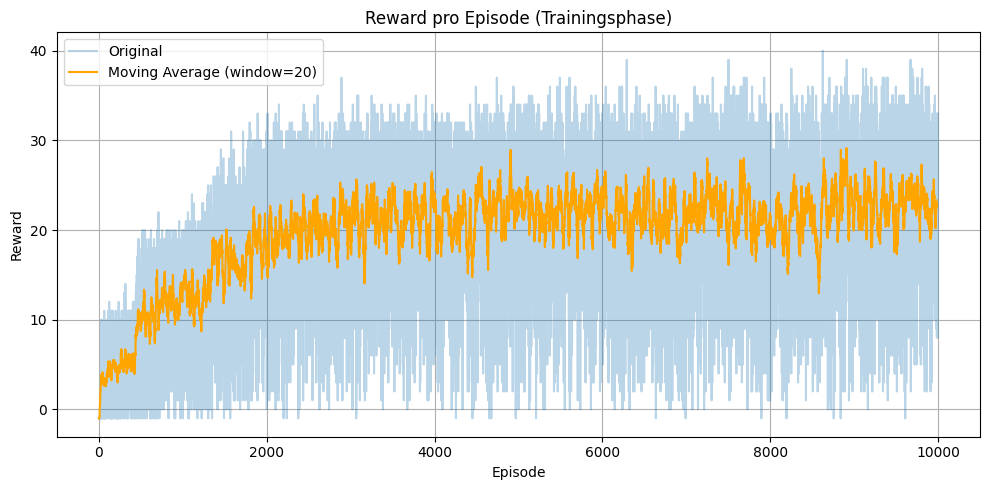


Starte Evaluation des trainierten Agenten...


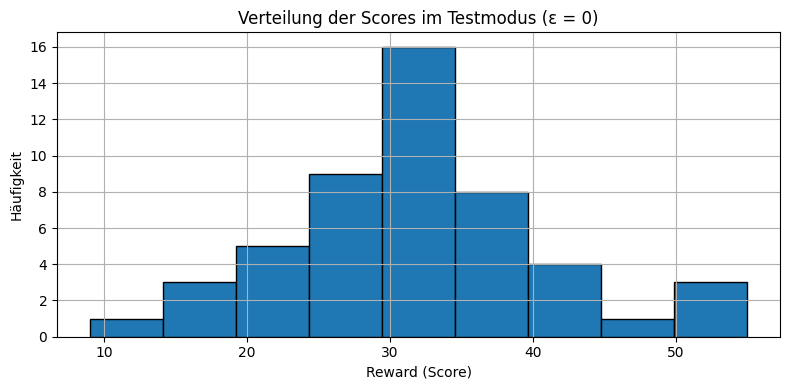

Durchschnittlicher Score über 50 Testspiele: 31.80
Maximaler Score im Test: 55


In [11]:
# Parameter
EPISODES = 10000
MAX_STEPS = 500
NUM_EVAL_EPISODES = 50
MOVING_AVG_WINDOW = 20

# Umgebung & Agent
env = SnakeGame()
agent = QLearningAgent(actions=[0, 1, 2])

scores = []

# Training
print("Starte Training...\n")

for episode in trange(EPISODES, desc="Training"):
    state = env.reset()
    total_reward = 0

    for _ in range(MAX_STEPS):
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if done:
            break

    scores.append(total_reward)

# Gleitender Durchschnitt berechnen
def moving_average(data, window=MOVING_AVG_WINDOW):
    return np.convolve(data, np.ones(window)/window, mode='valid')

smoothed_scores = moving_average(scores)

# Plot: Trainingsverlauf
plt.figure(figsize=(10, 5))
plt.plot(scores, alpha=0.3, label="Original")
plt.plot(range(len(smoothed_scores)), smoothed_scores, color='orange', label=f"Moving Average (window={MOVING_AVG_WINDOW})")
plt.title("Reward pro Episode (Trainingsphase)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
print("\nStarte Evaluation des trainierten Agenten...")

agent.epsilon = 0  # keine Zufallsaktionen
eval_scores = []

for _ in range(NUM_EVAL_EPISODES):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.choose_action(state)
        state, reward, done, _ = env.step(action)
        total_reward += reward

    eval_scores.append(total_reward)

# Plot: Score-Histogramm
plt.figure(figsize=(8, 4))
plt.hist(eval_scores, bins='auto', edgecolor='black')
plt.title("Verteilung der Scores im Testmodus (ε = 0)")
plt.xlabel("Reward (Score)")
plt.ylabel("Häufigkeit")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ergebnis
print(f"Durchschnittlicher Score über {NUM_EVAL_EPISODES} Testspiele: {np.mean(eval_scores):.2f}")
print(f"Maximaler Score im Test: {np.max(eval_scores)}")

## 💾 Modell speichern
Die Q-Tabelle wird als `.pkl` gespeichert, um sie später erneut zu laden.

In [9]:
agent.save("q_table.pkl")
print("Q-Tabelle gespeichert ✅")

Q-Tabelle gespeichert ✅


## 🎮 Live-Demo: Trainierter Agent spielt Snake
Hier beobachtest du den Agenten in Aktion.

In [10]:
env = SnakeGame()
agent = QLearningAgent(actions=[0, 1, 2])
agent.load("q_table.pkl")
agent.epsilon = 0

NUM_GAMES = 3

for i in range(1, NUM_GAMES + 1):
    state = env.reset()
    done = False
    score = 0

    print(f"\n🎮 Starte Spiel {i}...")

    while not done:
        action = agent.choose_action(state)
        state, reward, done, _ = env.step(action)
        score += reward
        env.render()
        time.sleep(0.1)

    print(f"🏁 Spiel {i} beendet. Score: {score}")
    time.sleep(1)


🎮 Starte Spiel 1...


KeyboardInterrupt: 